# Lecture 22 - Multiclass Classification Example, end-to-end

#### Goals:

* Cover no new concepts
* Put a whole supervised learning system together end-to-end from scratch.
* 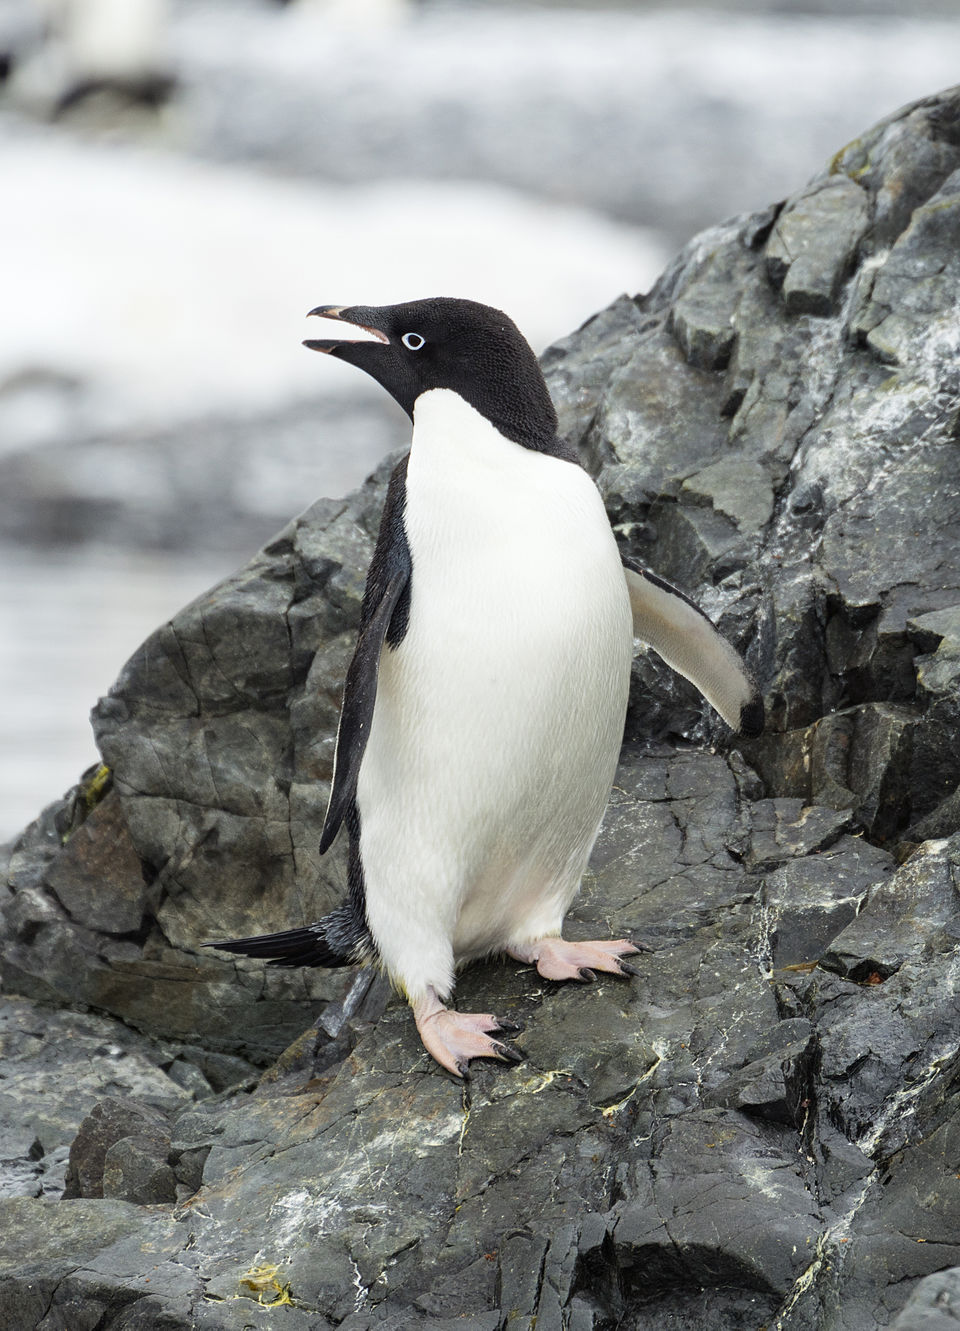
  (Image by Andrew Shiva / Wikipedia, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=46714803)

**Our goal**: predict a penguin's species given all available information about them (except, of course, their species).

In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [184]:
RANDOM_SEED = 42

## 1: Load and Split the Data

In [185]:
penguins = sns.load_dataset("penguins").dropna()

In [186]:
# separate features from labels
features = penguins.drop(columns="species")
labels = penguins["species"]

In [189]:
labels

0      Adelie
1      Adelie
2      Adelie
4      Adelie
5      Adelie
        ...  
338    Gentoo
340    Gentoo
341    Gentoo
342    Gentoo
343    Gentoo
Name: species, Length: 333, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

VAL_SIZE = 75
TEST_SIZE = 33

features_rest, features_test, labels_rest, labels_test = sklearn.model_selection.train_test_split(
    features, labels
    test_size=TEST_SIZE,
    shuffle=True, # default
    stratify=labels,
    random_state=RANDOM_SEED,
)

features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(
    features_rest, labels_rest
    test_size = VAL_SIZE,
    shuffle=True,
    stratify=labels_rest,
    random_state=RANDOM_SEED,
)

## 2: Baselines

In [192]:
labels_train.value_counts()

species
Adelie       99
Gentoo       80
Chinstrap    46
Name: count, dtype: int64

If we predict the most common label ("Adelie"), we'll get 99 of 250 correct. Our accuracy will be:

In [195]:
labels_train.value_counts().iloc[0] / labels_train.shape[0]

np.float64(0.44)

I could also calculate random guessing (or random guessing with probabilities weighted by the the class balance. I don't expect any other baseline to beat the above.

## 3. Feature Extraction 

In [213]:
numerical_features = [
    #'bill_length_mm',
    #'bill_depth_mm',
    #'flipper_length_mm',
    'body_mass_g'
]

categorical_features = [
    #"island",
    "sex"
]

# Z-score calculation code adapted from Lecture 18
def standardize_column(col):
    """ Given a numerical column as a Series, standardize to z-scores. """
    return (col - col.mean()) / col.std()

# one-hot encoding code adapted from Lecture 18
def one_hot(col):
    """ Given a categorical column as a Series, return a DataFrame with 
    one-hot encoded columns. """
    values = sorted(list(col.unique()))
    result = {}
    for v in values:
        result[v] = (col == v).astype(float)
    return pd.DataFrame(result)

def ordinal_encode(col):
    values = sorted(list(col.unique()))
    return col.map(dict(zip(values, range(len(values)))))

def extract_features(feature_df):
    """ Return a DataFrame with feature vectors extracted from
    the given DataFrame. """
    result_df = pd.DataFrame({})
    
    # standardize numerical columns; we could also use sklearn's StandardScaler
    for num_col in numerical_features:
        result_df[num_col] = standardize_column(feature_df[num_col])

    # one-hot encode categorical features; we could also use sklearn's OneHotEncoder
    for cat_col in categorical_features:
        encoded_df = one_hot(feature_df[cat_col])
        for col in encoded_df.columns:
            result_df[col] = encoded_df[col]

    return result_df



In [214]:
# now apply feature extraction to all three data splits:

X_train = extract_features(features_train).to_numpy()
X_val = extract_features(features_val).to_numpy()
X_test = extract_features(features_test).to_numpy()

# we'll use ordinal encoding for the labels:
y_train = ordinal_encode(labels_train).to_numpy()
y_val = ordinal_encode(labels_val).to_numpy()
y_test = ordinal_encode(labels_test).to_numpy()

## 4. Learn the Machine!

In [219]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train);

## 5. Evaluate Performance

In [220]:
def evaluate(classifier, X_train, y_train, X_val, y_val):
    # Classification accuracy on training and validation sets:

    y_train_pred = knn.predict(X_train)
    y_val_pred   = knn.predict(X_val)

    train_acc = (y_train_pred == y_train).sum() / y_train.shape[0]
    val_acc   = (y_val_pred == y_val).sum() / y_val.shape[0]
    
    print(f"Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

In [221]:
evaluate(knn, X_train, y_train, X_val, y_val)

Training accuracy: 0.8089 (80.89%)
Validation accuracy: 0.8133 (81.33%)
